In [1]:
%reset -f

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/

/content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
layers= tf.keras.layers

from Euler.param import Param
from Euler.neural_networks import *

## Mise au point du kernel tricky

In [5]:


shift_eye(5,3,1)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

## Testons-le

In [7]:
def periodic_padding(W, pad):
    left = W[:, :pad, :]
    right = W[:, -pad:, :]
    return tf.concat([right, W, left], axis=1)

In [8]:
dim_features=2
#attention, c'est pas le window_size-1 
window_size=5

x = np.arange(20).astype(np.float32)
X=[]
for j in range(dim_features):
    X.append(x*10**j)
X=np.stack(X,axis=1)[np.newaxis,:,:]

X=periodic_padding(X,window_size//2).numpy()


print(X.astype(int))
print(X.shape)

[[[ 18 180]
  [ 19 190]
  [  0   0]
  [  1  10]
  [  2  20]
  [  3  30]
  [  4  40]
  [  5  50]
  [  6  60]
  [  7  70]
  [  8  80]
  [  9  90]
  [ 10 100]
  [ 11 110]
  [ 12 120]
  [ 13 130]
  [ 14 140]
  [ 15 150]
  [ 16 160]
  [ 17 170]
  [ 18 180]
  [ 19 190]
  [  0   0]
  [  1  10]]]
(1, 24, 2)


In [9]:
X_L=X[:,:-1,:]
X_R=X[:,1:,:]
X_L.shape,X_R.shape

((1, 23, 2), (1, 23, 2))

In [10]:
tricky_convo=create_tricy_convo(window_size-1,dim_features)
Y_L=tricky_convo(X_L)


print(Y_L.numpy().astype(int))
print(Y_L.shape)

[[[ 18  19   0   1 180 190   0  10]
  [ 19   0   1   2 190   0  10  20]
  [  0   1   2   3   0  10  20  30]
  [  1   2   3   4  10  20  30  40]
  [  2   3   4   5  20  30  40  50]
  [  3   4   5   6  30  40  50  60]
  [  4   5   6   7  40  50  60  70]
  [  5   6   7   8  50  60  70  80]
  [  6   7   8   9  60  70  80  90]
  [  7   8   9  10  70  80  90 100]
  [  8   9  10  11  80  90 100 110]
  [  9  10  11  12  90 100 110 120]
  [ 10  11  12  13 100 110 120 130]
  [ 11  12  13  14 110 120 130 140]
  [ 12  13  14  15 120 130 140 150]
  [ 13  14  15  16 130 140 150 160]
  [ 14  15  16  17 140 150 160 170]
  [ 15  16  17  18 150 160 170 180]
  [ 16  17  18  19 160 170 180 190]
  [ 17  18  19   0 170 180 190   0]]]
(1, 20, 8)


In [11]:
Y_R=tricky_convo(X_R)

print(Y_R.numpy().astype(int))
print(Y_R.shape)

[[[ 19   0   1   2 190   0  10  20]
  [  0   1   2   3   0  10  20  30]
  [  1   2   3   4  10  20  30  40]
  [  2   3   4   5  20  30  40  50]
  [  3   4   5   6  30  40  50  60]
  [  4   5   6   7  40  50  60  70]
  [  5   6   7   8  50  60  70  80]
  [  6   7   8   9  60  70  80  90]
  [  7   8   9  10  70  80  90 100]
  [  8   9  10  11  80  90 100 110]
  [  9  10  11  12  90 100 110 120]
  [ 10  11  12  13 100 110 120 130]
  [ 11  12  13  14 110 120 130 140]
  [ 12  13  14  15 120 130 140 150]
  [ 13  14  15  16 130 140 150 160]
  [ 14  15  16  17 140 150 160 170]
  [ 15  16  17  18 150 160 170 180]
  [ 16  17  18  19 160 170 180 190]
  [ 17  18  19   0 170 180 190   0]
  [ 18  19   0   1 180 190   0  10]]]
(1, 20, 8)


## Trainable

In [12]:
for var in tricky_convo.trainable_variables:
    print(var.shape)

In [13]:
for var in tricky_convo.non_trainable_variables:
    print(var.shape)

(4, 2, 8)
(8,)


In [14]:
tricky_convo.trainable=True

In [15]:
for var in tricky_convo.trainable_variables:
    print(var.shape)

(4, 2, 8)
(8,)


In [16]:
for var in tricky_convo.non_trainable_variables:
    print(var.shape)

## Et en cas d'inversion

On peut imaginer, que pour calculer la valeur droite, ce soit intéressant d'inverser l'ordre de la fenêtre.

NON, sans doute pas: il faudrait changer le solver pour cela ... 

In [17]:
Y_inversed=tricky_convo(X[:,::-1,:])[:,::-1,:]
print(Y_inversed.numpy().astype(int))
print(Y_inversed.shape)

[[[  1   0  19  18  10   0 190 180]
  [  2   1   0  19  20  10   0 190]
  [  3   2   1   0  30  20  10   0]
  [  4   3   2   1  40  30  20  10]
  [  5   4   3   2  50  40  30  20]
  [  6   5   4   3  60  50  40  30]
  [  7   6   5   4  70  60  50  40]
  [  8   7   6   5  80  70  60  50]
  [  9   8   7   6  90  80  70  60]
  [ 10   9   8   7 100  90  80  70]
  [ 11  10   9   8 110 100  90  80]
  [ 12  11  10   9 120 110 100  90]
  [ 13  12  11  10 130 120 110 100]
  [ 14  13  12  11 140 130 120 110]
  [ 15  14  13  12 150 140 130 120]
  [ 16  15  14  13 160 150 140 130]
  [ 17  16  15  14 170 160 150 140]
  [ 18  17  16  15 180 170 160 150]
  [ 19  18  17  16 190 180 170 160]
  [  0  19  18  17   0 190 180 170]
  [  1   0  19  18  10   0 190 180]]]
(1, 21, 8)


## La classe

In [18]:
param=Param()

Param initialised with, nx=2000, nx_coarse=199, batch_size=25


In [19]:
model_struct_default=(32,64,32)

In [21]:
model=Difference_model_tricky(param,5)
X=np.random.uniform(size=[param.batch_size,param.nx,param.augmentation_dim])
print(X.shape)

(25, 2000, 8)


In [22]:
Y=model(X)
Y

<tf.Tensor: shape=(25, 2000, 3), dtype=float32, numpy=
array([[[ 0.029,  0.024,  0.07 ],
        [ 0.129,  0.018, -0.192],
        [-0.057, -0.09 ,  0.14 ],
        ...,
        [-0.191, -0.059, -0.049],
        [ 0.306,  0.005, -0.081],
        [-0.219,  0.051,  0.147]],

       [[-0.081, -0.149, -0.108],
        [ 0.34 ,  0.115, -0.053],
        [-0.314, -0.012,  0.118],
        ...,
        [ 0.241,  0.176,  0.043],
        [-0.252, -0.099, -0.046],
        [ 0.099,  0.196,  0.182]],

       [[ 0.015,  0.271,  0.137],
        [-0.056, -0.042,  0.118],
        [ 0.144,  0.049, -0.002],
        ...,
        [ 0.105, -0.075, -0.115],
        [-0.03 , -0.16 , -0.036],
        [-0.1  ,  0.057, -0.082]],

       ...,

       [[-0.043,  0.103,  0.055],
        [ 0.191, -0.022, -0.023],
        [-0.162, -0.016, -0.003],
        ...,
        [ 0.407,  0.012, -0.14 ],
        [-0.173,  0.066,  0.152],
        [-0.078, -0.246, -0.174]],

       [[-0.017, -0.45 , -0.317],
        [ 0.22 ,  0.30

## TOTO

In [23]:
data = np.arange(0, 12, 1)
W = np.stack([data, data], axis=1)
W = W[np.newaxis,:,:]
window_size=5

print("W.shape",W.shape)


res=rolling_window_stacking(W,window_size)
res.shape


W.shape (1, 12, 2)


TensorShape([1, 8, 5, 2])

In [ ]:
def test_rol_human():
    data = np.arange(0, 7, 1)
    W = np.stack([data, data], axis=1)
    W = W[np.newaxis,:,:]
    window_size=5
    W_roll=pad_and_roll(W,window_size,Param(),roll_via_stacking=True)
    print("W.shape:",W.shape)
    print("W_roll.shape:",W_roll.shape)
    print("unrol(W_roll)-W:\n",unrol(W_roll,window_size)-W)
    print("W:\n",W)
    print("W_roll\n",W_roll)

test_rol_human()

## Entrainement

In [26]:
X=np.random.uniform(size=[param.batch_size,param.nx,param.augmentation_dim])

### le nouveau modèle avec accélération @tf.function

In [27]:
@tf.function
def minimize(model,X,optimizer):
    with tf.GradientTape() as tape:
        Y=model(X)
        loss=tf.reduce_mean(tf.abs(Y))
    gradients=tape.gradient(loss,model.keras_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.keras_model.trainable_variables))
    return loss

In [29]:
model=Difference_model_tricky(param,5)
optimizer=tf.keras.optimizers.Adam()

In [30]:
%%time
losses=[]
for _ in range(300):
    loss=minimize(model,X,optimizer)
    losses.append(loss)

CPU times: user 2.37 s, sys: 883 ms, total: 3.26 s
Wall time: 3.17 s


In [32]:
model=Difference_model_addi(param,5,roll_via_stacking=True)
optimizer=tf.keras.optimizers.Adam()

In [33]:
%%time
losses_stack=[]
for _ in range(300):
    loss=minimize(model,X,optimizer)
    losses_stack.append(loss)

NotImplementedError: ignored

### L'ancien sans l'accélération

In [28]:
#@tf.function
def minimize(model,X,optimizer):
    with tf.GradientTape() as tape:
        Y=model(X)
        loss=tf.reduce_mean(tf.abs(Y))
    gradients=tape.gradient(loss,model.keras_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.keras_model.trainable_variables))
    return loss

In [31]:
model_old=Difference_model_addi(param,5)
optimizer=tf.keras.optimizers.Adam()

In [32]:
%%time
losses_old=[]
for _ in range(300):
    loss=minimize(model_old,X,optimizer)
    losses_old.append(loss)

CPU times: user 4 s, sys: 185 ms, total: 4.19 s
Wall time: 5.18 s


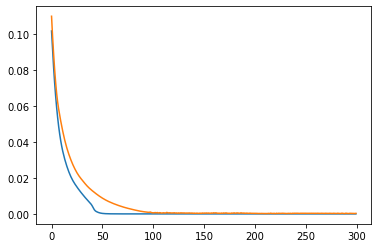

In [33]:
plt.plot(losses)
plt.plot(losses_old)